In [156]:
#LIBRARIES
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from datetime import datetime
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import random
import nibabel as nib
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.data import Dataset, CacheDataset, DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.transforms import (
    AsDiscrete,
    Compose,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    CropForegroundd,
)
from monai.networks.nets import SwinUNETR
import segmentation_models_pytorch as smp
import functions
import loaddata
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import transforms2

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#print_config()

experiment = "s4"
experiment_dir = f"/home/ilkin/Documents/2024PHD/segmentation/swinunetr/tests/OH-GLLES-3D/{experiment}"
json_path = f"{experiment_dir}/hyperparameters.json"

print(json_path)
if os.path.exists(json_path):
    with open(json_path, "r") as f:
        hyperparams = json.load(f)

print(hyperparams)

# Functions to get additional parameters
lossfunc = functions.get_loss_func(hyperparams["diceCE"])
label_names, numberofclasses = functions.get_classes(hyperparams["dataset"], hyperparams["seg"])
dimension, batchsize = functions.get_dimension_and_bs(hyperparams["dataset"])
dice_roi, aug_roi = functions.get_rois(hyperparams["dataset"], hyperparams["architecture"])


# Update hyperparameters
hyperparams.update({
    "experiment": experiment,
    "number_of_classes": numberofclasses,
    "dimension": dimension,
    "batch_size": batchsize,
    "dice_roi": dice_roi,
    "aug_roi": aug_roi,
    "date_time": datetime.now().strftime("%d/%m/%Y %H:%M:%S"),  # Log timestamp
    "loss_function": f"{lossfunc} ({hyperparams['wdice']}-{hyperparams['wce']})",
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    "patience": 10
})

# Save the updated hyperparameters back to the JSON file
with open(json_path, "w") as f:
    json.dump(hyperparams, f, indent=4)

print("Hyperparameters updated and saved.")

if hyperparams["server"]:
    data_dir = os.path.join("/data/ayc9699/dataset", hyperparams["dataset"])
else:
    data_dir = os.path.join("/home/ilkin/Documents/2024PHD/data", hyperparams["dataset"])


cuda
/home/ilkin/Documents/2024PHD/segmentation/swinunetr/tests/OH-GLLES-3D/s4/hyperparameters.json
{'caption': 'Planning-CTs ROI OH GTV swinUNETR with pretraining', 'experiment': 's4', 'dataset': 'Planning-CTs', 'seg': 'GTV', 'modified': False, 'architecture': 'swinUNETR', 'server': False, 'pretraining': True, 'max_iterations': 20000, 'eval_num': 250, 'diceCE': True, 'wdice': 0.5, 'wce': 1.0, 'train_rt': 0.8, 'val_rt': 0.1, 'test_rt': 0.1, 'scheduler': 'ReduceLROnPlateau', 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'patience': 10, 'num_folds': 5, 'number_of_classes': 1, 'dimension': 3, 'batch_size': 1, 'date_time': '30/01/2025 13:34:48', 'loss_function': 'DiceCE Loss (0.5-1.0)', 'dice_roi': [512, 512, 200], 'aug_roi': [64, 64, 64]}
Hyperparameters updated and saved.


In [157]:
fold_splits = loaddata.get_train_val_test_files_5fold_planning(
    dataset=hyperparams["dataset"],
    data_dir=data_dir,
    train_rt=hyperparams["train_rt"], 
    val_rt=hyperparams["val_rt"], 
    test_rt=hyperparams["test_rt"],
    output_dir=experiment_dir,
    seg=hyperparams["seg"],
    modified=False,
    num_folds=hyperparams["num_folds"],
)


test_transforms = transforms2.getTestTransformROI(-175, 250)

Total number of patients: 188
Fixed Test Patients: 18
Fold 1:
  Training Patients: 136
  Validation Patients: 34
  Test Patients: 18
Fold 2:
  Training Patients: 136
  Validation Patients: 34
  Test Patients: 18
Fold 3:
  Training Patients: 136
  Validation Patients: 34
  Test Patients: 18
Fold 4:
  Training Patients: 136
  Validation Patients: 34
  Test Patients: 18
Fold 5:
  Training Patients: 136
  Validation Patients: 34
  Test Patients: 18


Patient: 2013KEFR, Slice: 32


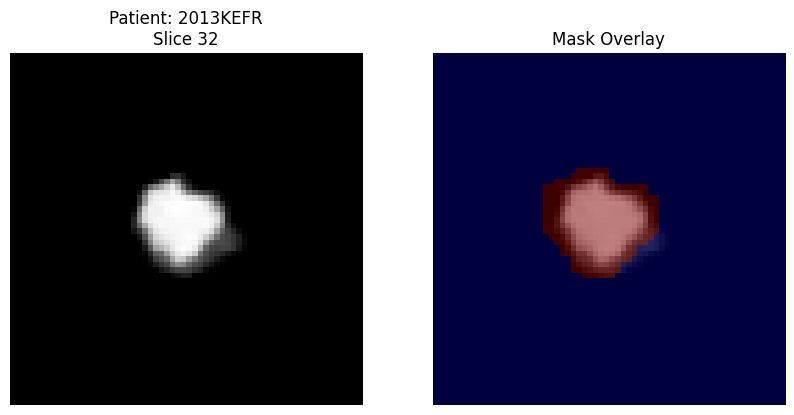

Patient: 2013HOJA, Slice: 32


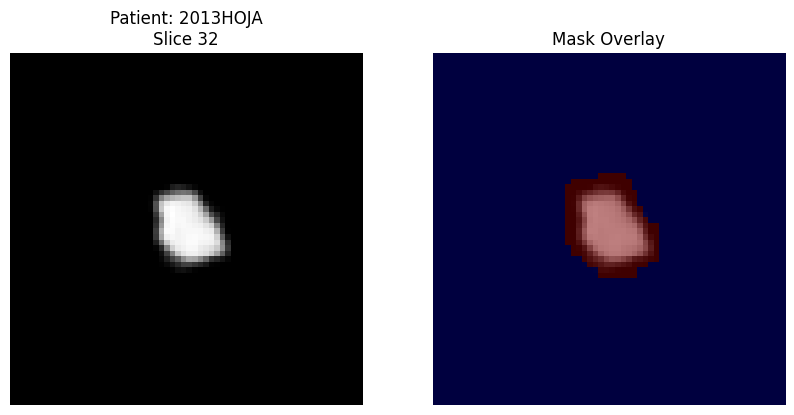

Patient: 2012JOJA, Slice: 32


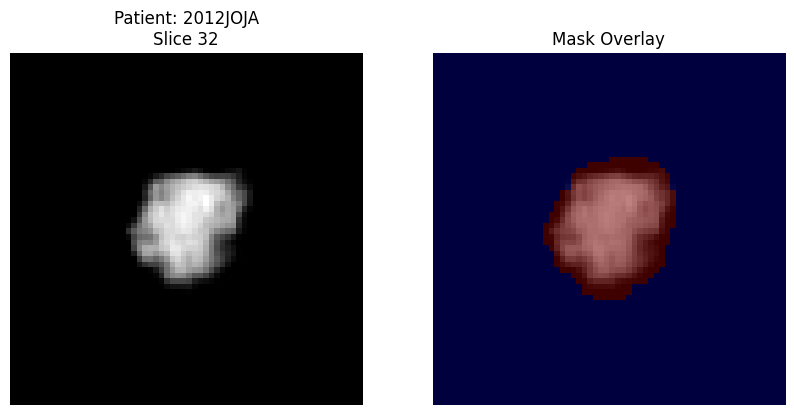

Patient: 2011TSMA, Slice: 32


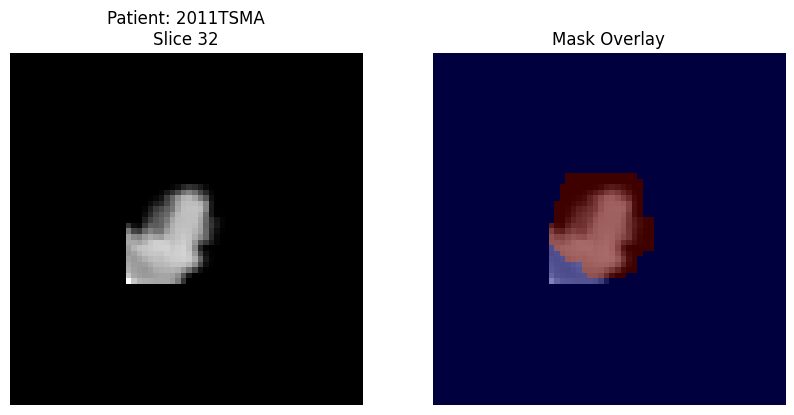

Patient: 2012ADJU, Slice: 32


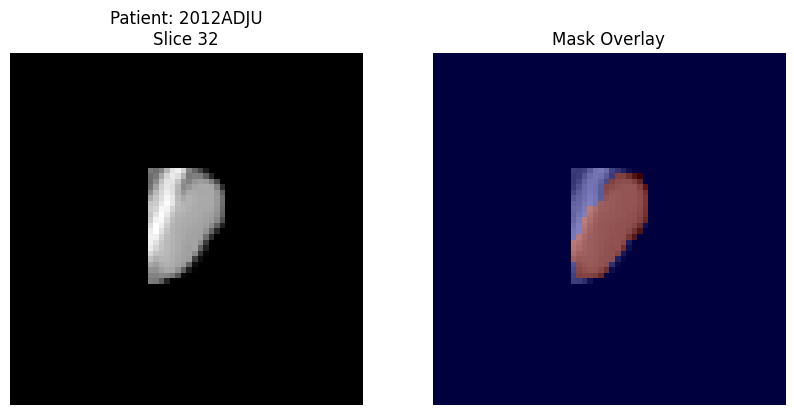

In [158]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from monai.data import Dataset

fold_idx = 0
# Create test dataset and loader
test_dataset = Dataset(data=fold_splits[fold_idx]["test_files"], transform=test_transforms)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define function to visualize images with segmentation masks
def visualize_batch_with_masks(sample_data, patient_name, slice_idx):
    sample_image = sample_data["image"][0]  # Extract first item from batch
    sample_mask = sample_data["mask"][0]  # Extract first item from batch

    # Convert image and mask to numpy arrays
    image_np = sample_image.squeeze().cpu().numpy()
    mask_np = sample_mask.squeeze().cpu().numpy()

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    if len(image_np.shape) == 3:  # If 3D, pick the middle slice
        image_slice = image_np[:, :, slice_idx]
        mask_slice = mask_np[:, :, slice_idx]
    else:  # If 2D, use the whole image
        image_slice = image_np
        mask_slice = mask_np

    # Print patient and slice information
    print(f"Patient: {patient_name}, Slice: {slice_idx}")

    # Plot image
    axes[0].imshow(image_slice, cmap="gray")
    axes[0].set_title(f"Patient: {patient_name}\nSlice {slice_idx}")
    axes[0].axis('off')

    # Plot mask overlay
    axes[1].imshow(image_slice, cmap="gray")
    axes[1].imshow(mask_slice, cmap="jet", alpha=0.5)
    axes[1].set_title("Mask Overlay")
    axes[1].axis('off')

    plt.show()

# Iterate through test data and visualize first 5 samples
for idx, sample_data in enumerate(test_data_loader):
    if idx >= 5:  # Stop after 5 samples
        break

    # Extract patient name from metadata (assuming metadata contains patient info)
    patient_name = sample_data["patient_id"][0]  # Adjust if needed

    # Determine slice index if 3D
    sample_image = sample_data["image"][0].squeeze().cpu().numpy()
    slice_idx = sample_image.shape[2] // 2 if len(sample_image.shape) == 3 else 0

    # Print and visualize
    visualize_batch_with_masks(sample_data, patient_name, slice_idx)


In [13]:
#DEFINE MODEL 

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=numberofclasses+1,
    feature_size=48,
    use_checkpoint=True,
).to(device)


In [81]:
torch.backends.cudnn.benchmark = False
fold_idx = 4 #fold5
fold_dir = os.path.join(experiment_dir, f"fold_{fold_idx+1}")
print(len(fold_splits))
fold_split = fold_splits[fold_idx]

model.load_state_dict(torch.load(os.path.join(fold_dir,"best_metric_model.pth")))
# Evaluation on Test Data
test_loader = DataLoader(
    CacheDataset(data=fold_splits[fold_idx]["test_files"], transform=test_transforms, cache_rate=0.1, num_workers=4),
    batch_size=batchsize, shuffle=True, num_workers=4
)


5


Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Patient: 2013KEFR / CT-Plan-image.nii.gz
31
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 1035 GT Pixel Count: 786
Shrunk Predicted Pixel Count: 818 Expanded Predicted Pixel Count: 1266


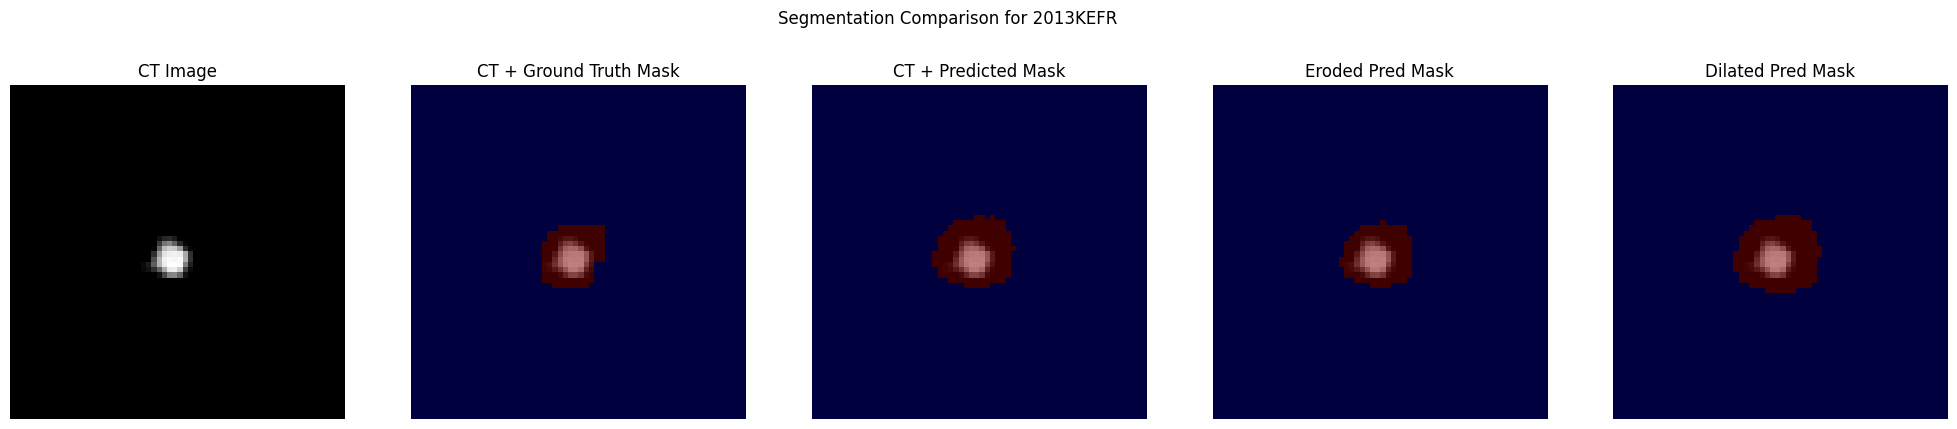

Patient: 2013HOJA / CT-Plan-image.nii.gz
32
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 4791 GT Pixel Count: 3784
Shrunk Predicted Pixel Count: 4153 Expanded Predicted Pixel Count: 5465


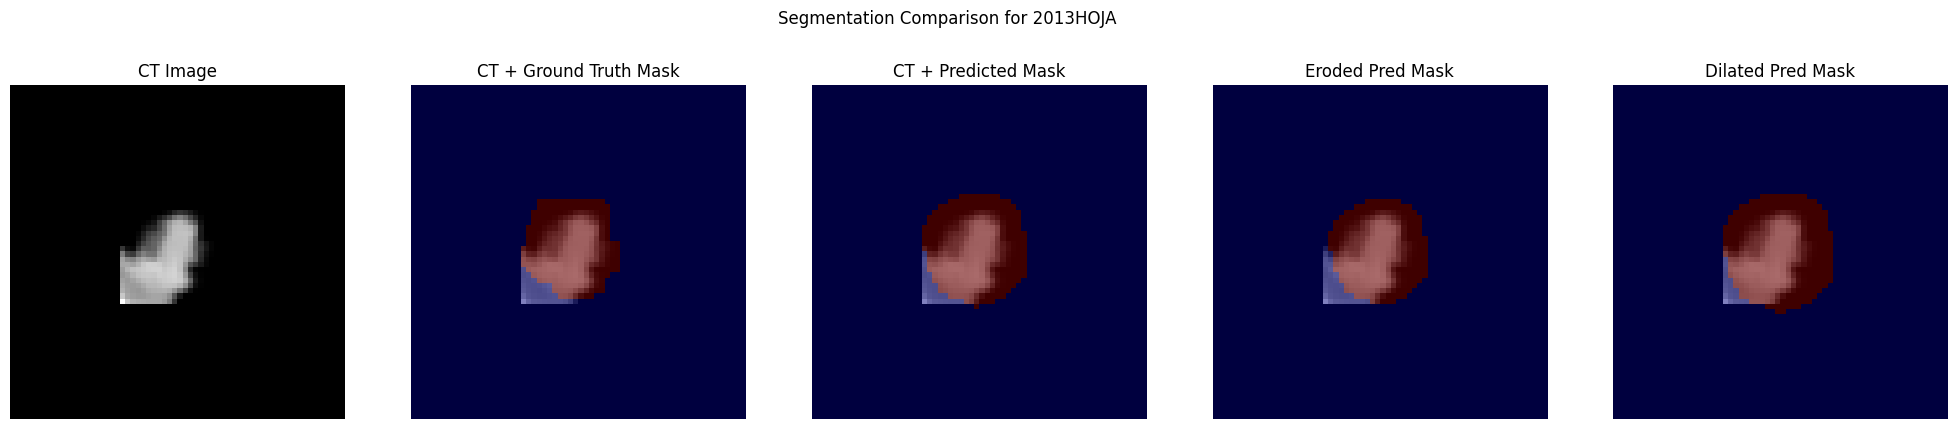

Patient: 2012JOJA / CT-Plan-image.nii.gz
31
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 5965 GT Pixel Count: 9320
Shrunk Predicted Pixel Count: 5170 Expanded Predicted Pixel Count: 6804


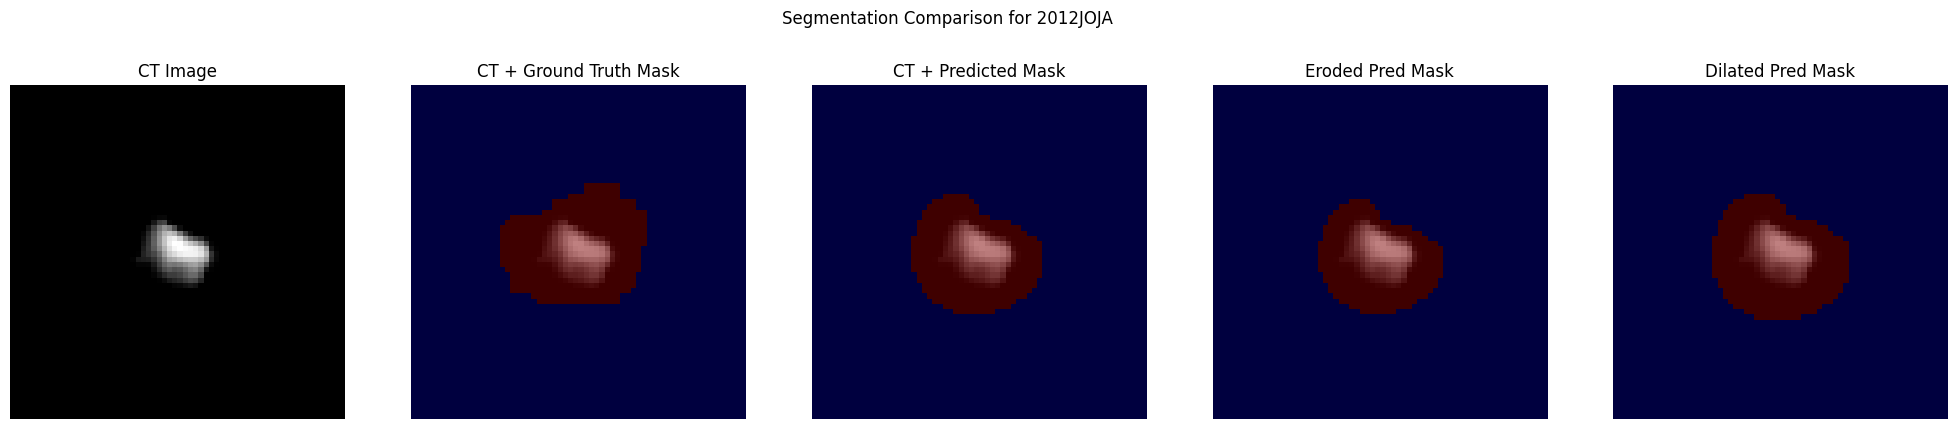

Patient: 2011TSMA / CT-Plan-image.nii.gz
31
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 1319 GT Pixel Count: 1484
Shrunk Predicted Pixel Count: 1011 Expanded Predicted Pixel Count: 1659


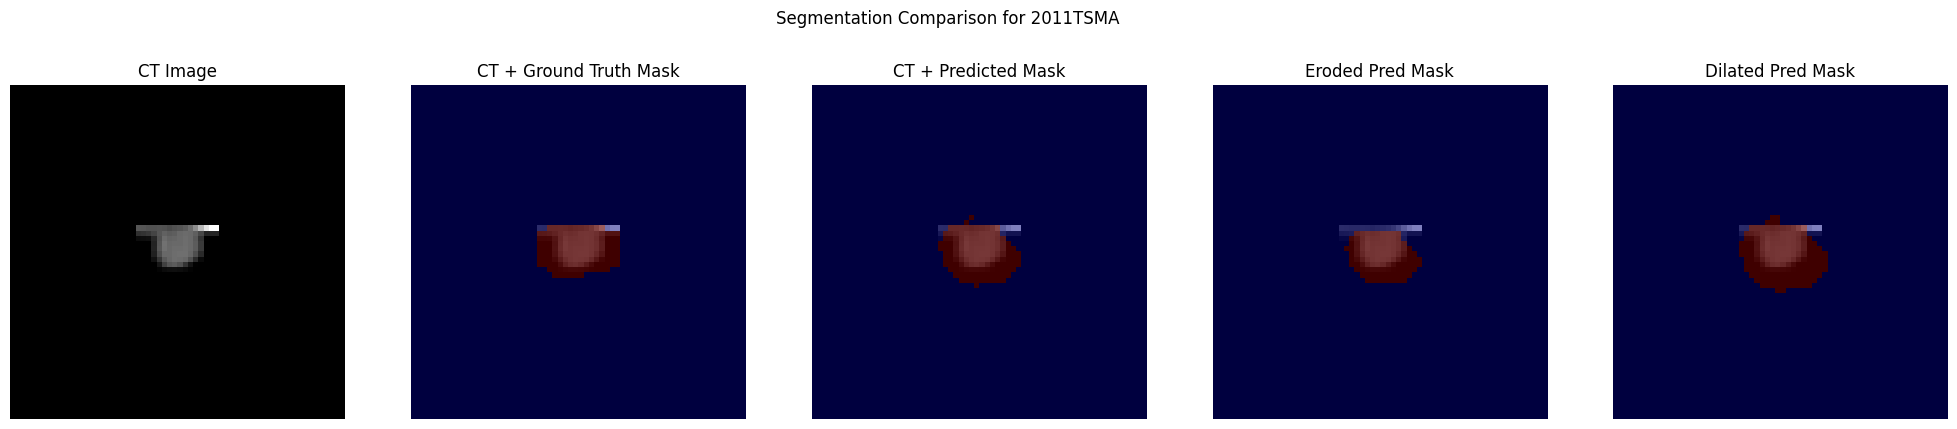

Patient: 2012ADJU / CT-Plan-image.nii.gz
31
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 3020 GT Pixel Count: 4495
Shrunk Predicted Pixel Count: 2495 Expanded Predicted Pixel Count: 3583


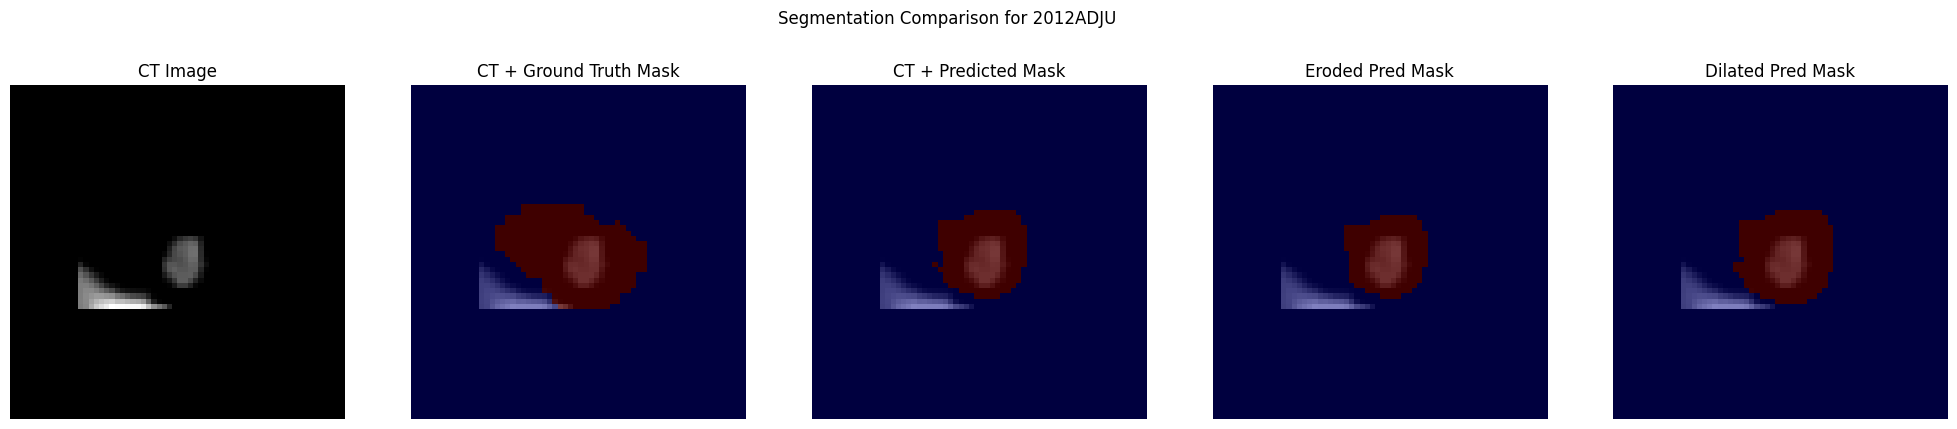

Patient: 2015SCWI / CT-Plan-image.nii.gz
32
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 2179 GT Pixel Count: 1480
Shrunk Predicted Pixel Count: 1842 Expanded Predicted Pixel Count: 2537


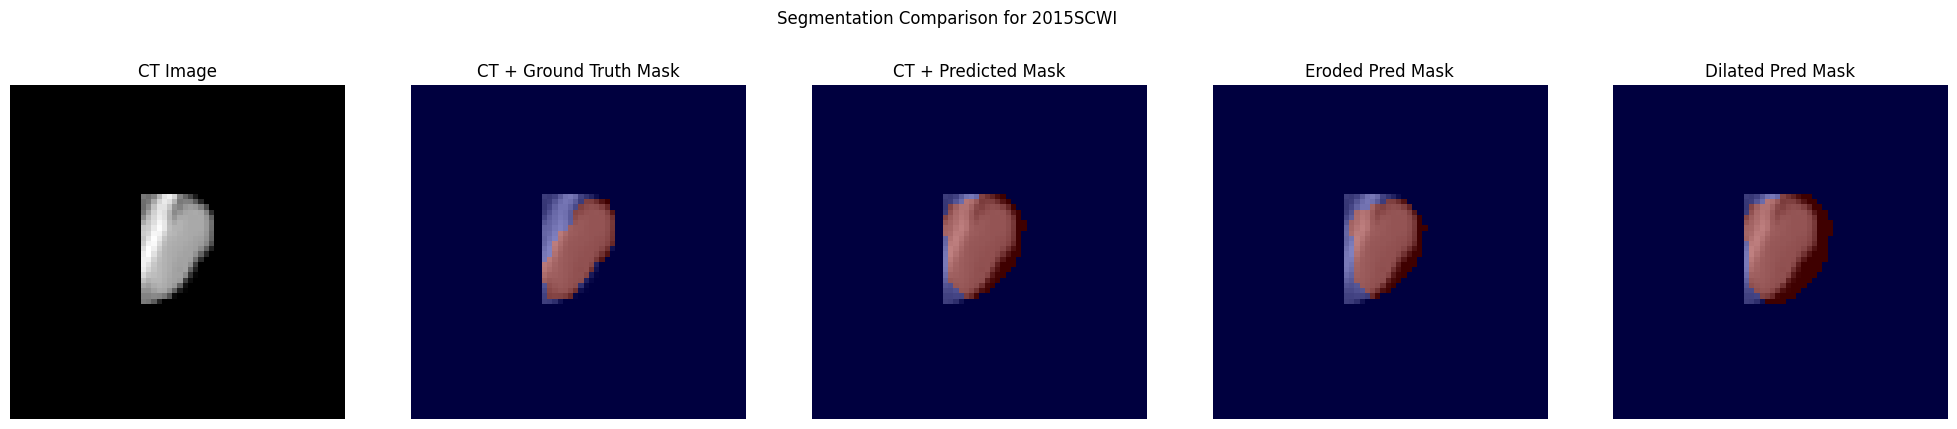

Patient: 2017HADO / CT-Plan-image.nii.gz
32
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 2214 GT Pixel Count: 2635
Shrunk Predicted Pixel Count: 1814 Expanded Predicted Pixel Count: 2637


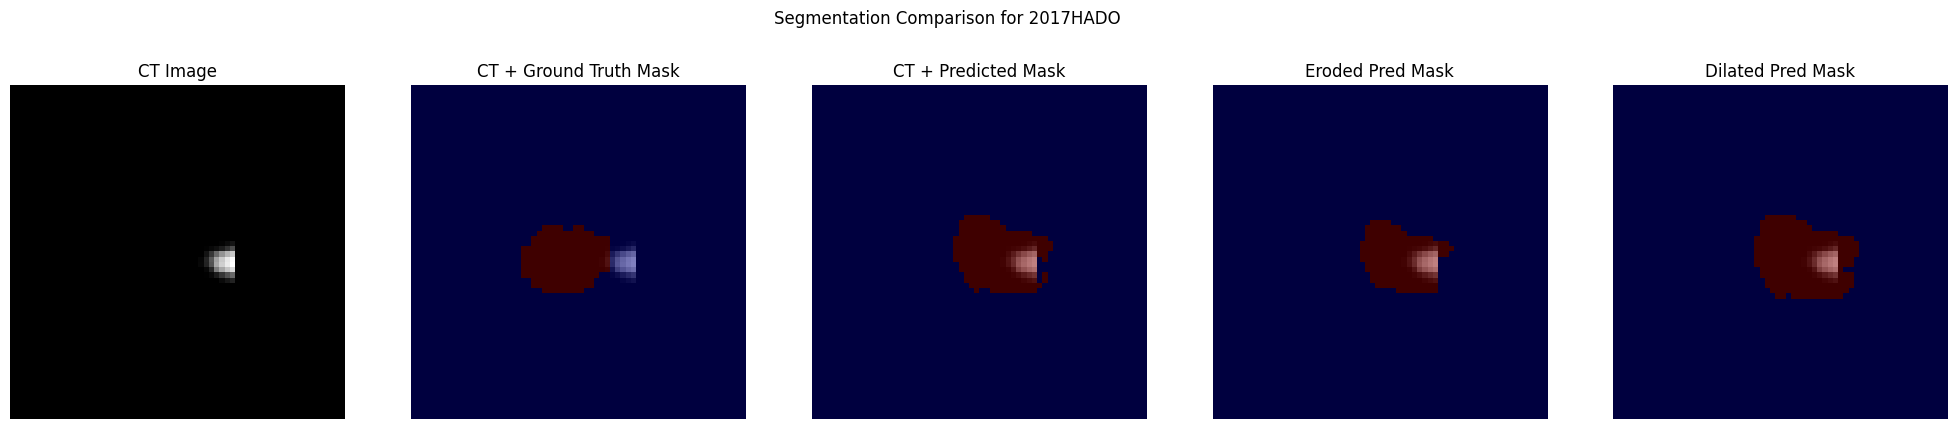

Patient: 2012JODO / CT-Plan-image.nii.gz
32
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 4484 GT Pixel Count: 3970
Shrunk Predicted Pixel Count: 3782 Expanded Predicted Pixel Count: 5230


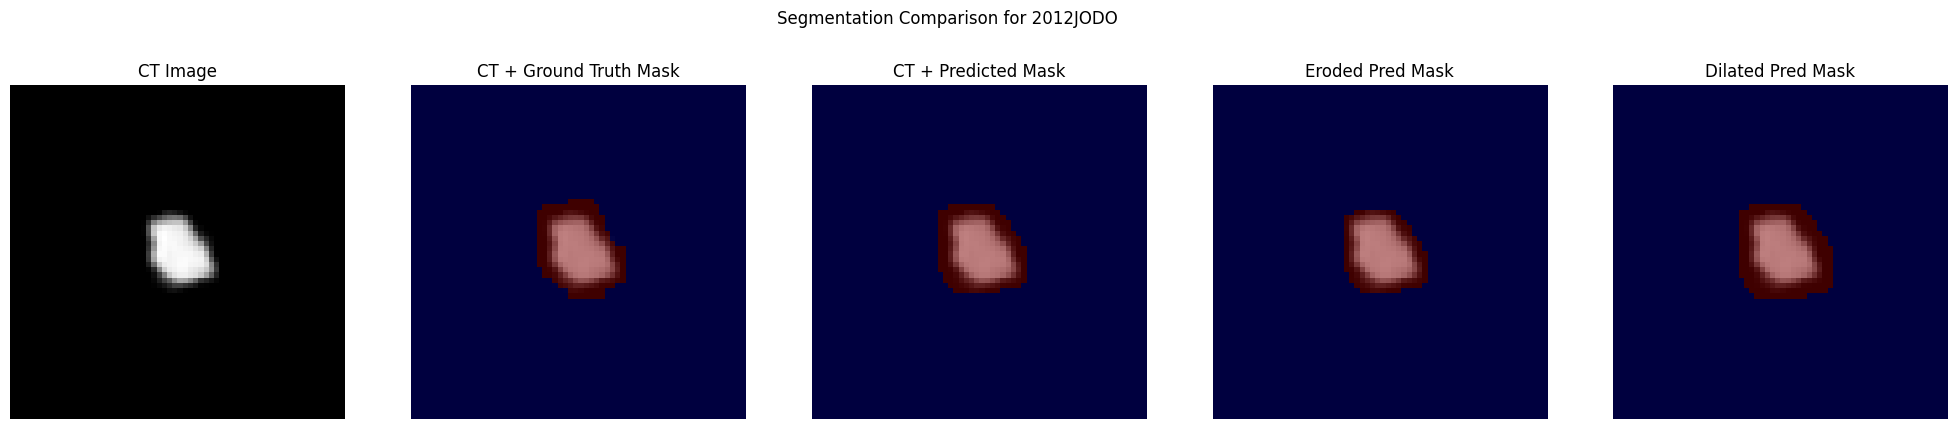

Patient: 2017BAHE / CT-Plan-image.nii.gz
31
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 11406 GT Pixel Count: 14419
Shrunk Predicted Pixel Count: 10106 Expanded Predicted Pixel Count: 12768


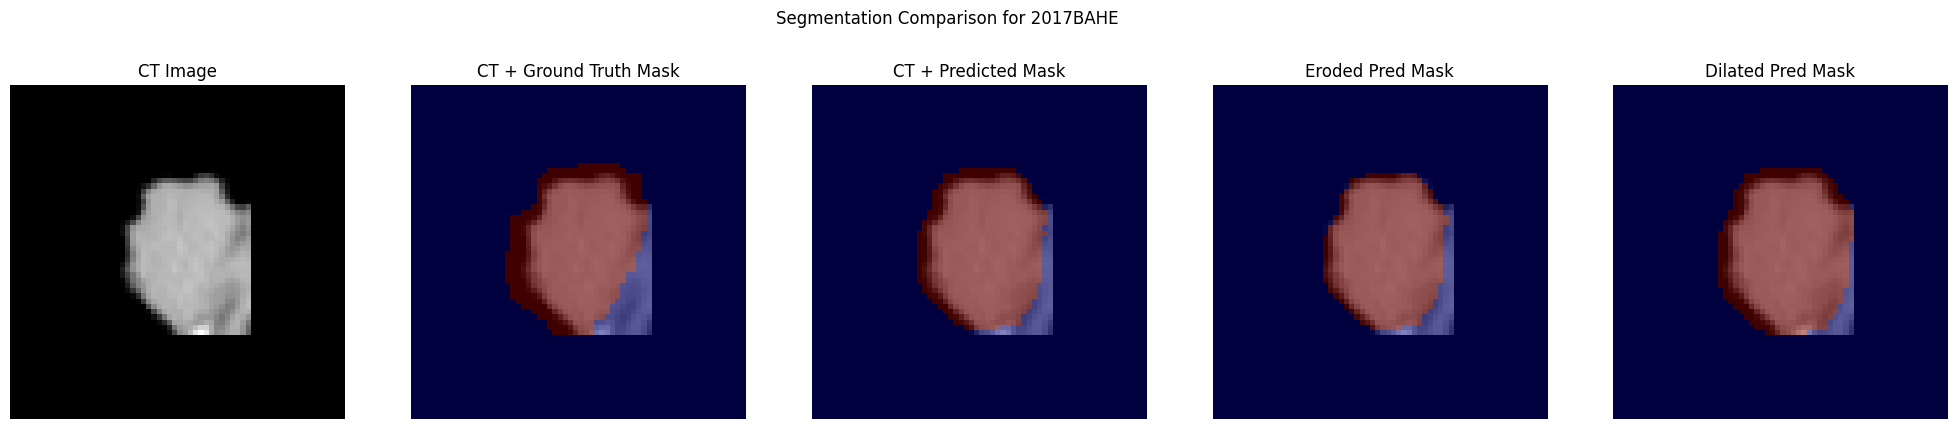

Patient: 2018CAJO(1) / CT-Plan-image.nii.gz
32
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 5019 GT Pixel Count: 4098
Shrunk Predicted Pixel Count: 4368 Expanded Predicted Pixel Count: 5702


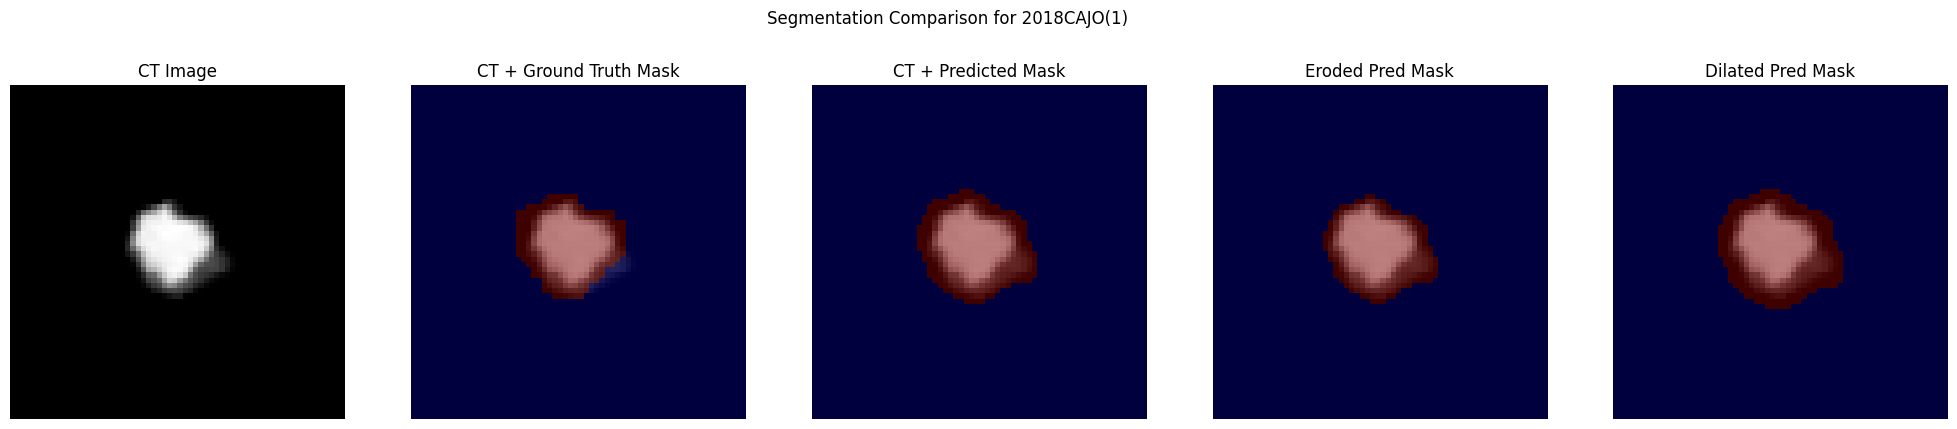

Patient: 2012LAJI / CT-Plan-image.nii.gz
31
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 4765 GT Pixel Count: 4258
Shrunk Predicted Pixel Count: 4082 Expanded Predicted Pixel Count: 5490


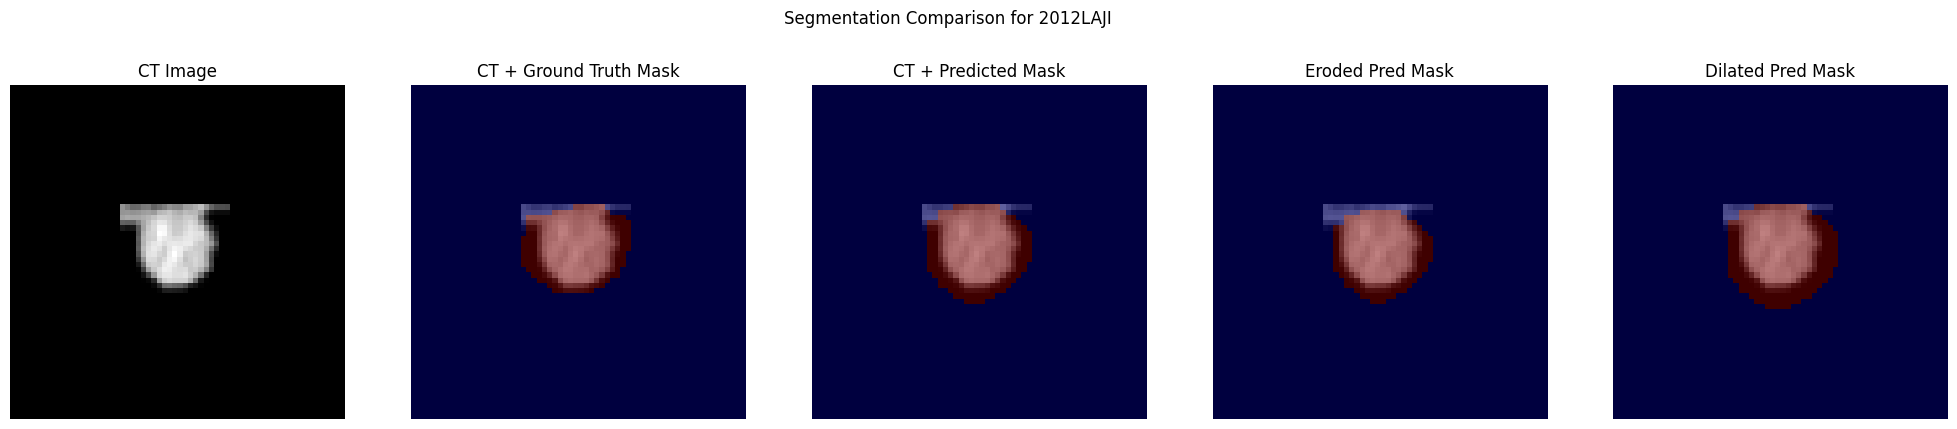

Patient: 2012RITH / CT-Plan-image.nii.gz
31
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 999 GT Pixel Count: 1112
Shrunk Predicted Pixel Count: 767 Expanded Predicted Pixel Count: 1255


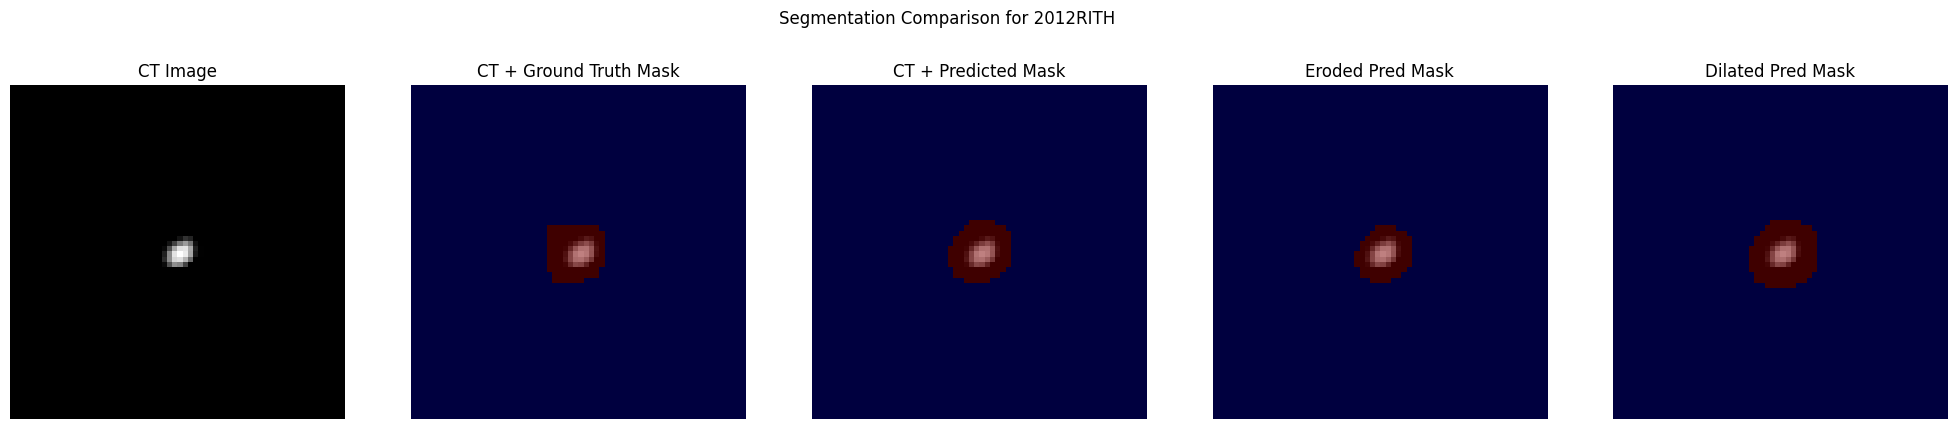

Patient: 2013JOLE / CT-Plan-image.nii.gz
32
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 2206 GT Pixel Count: 3688
Shrunk Predicted Pixel Count: 1801 Expanded Predicted Pixel Count: 2643


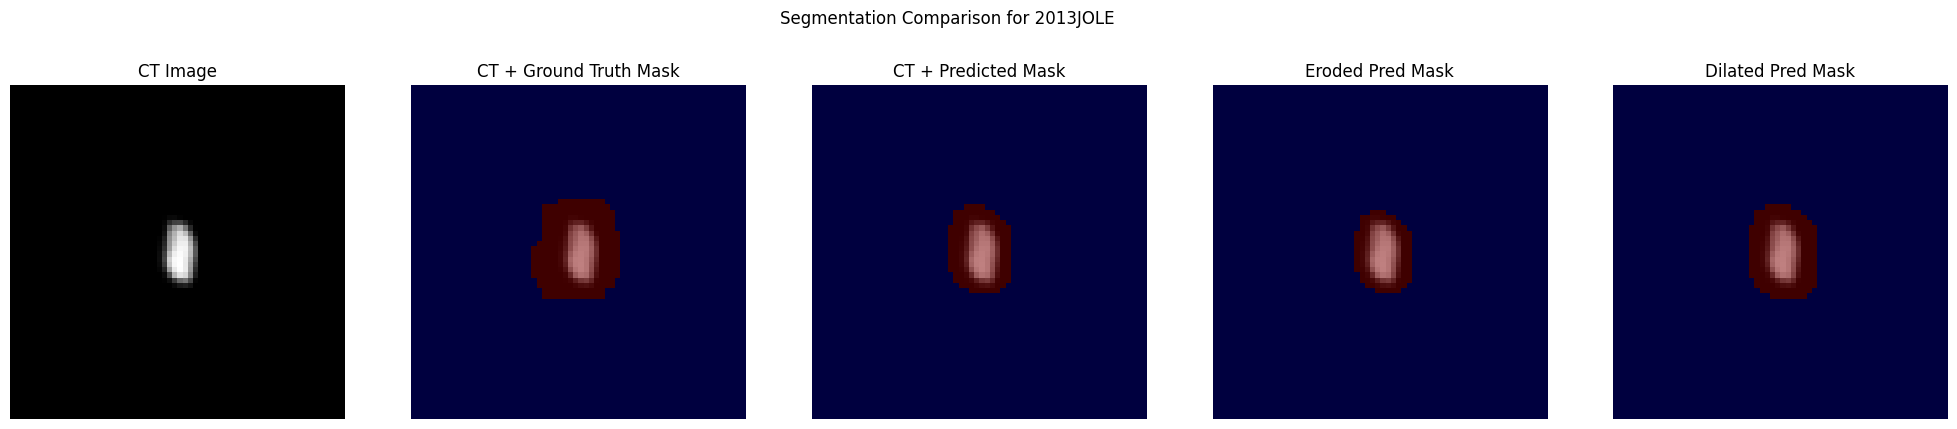

Patient: 2013LASH / CT-Plan-image.nii.gz
32
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 10725 GT Pixel Count: 9497
Shrunk Predicted Pixel Count: 9576 Expanded Predicted Pixel Count: 11921


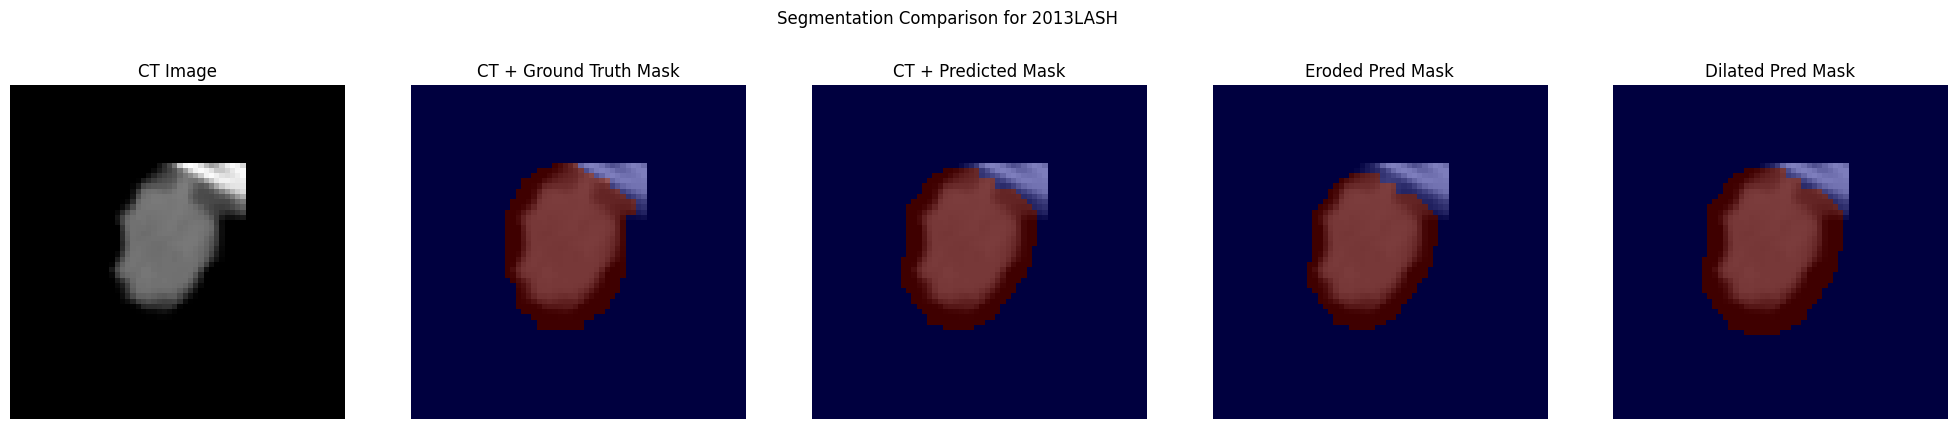

Patient: 2013PATH / CT-Plan-image.nii.gz
31
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 3424 GT Pixel Count: 4187
Shrunk Predicted Pixel Count: 2883 Expanded Predicted Pixel Count: 4004


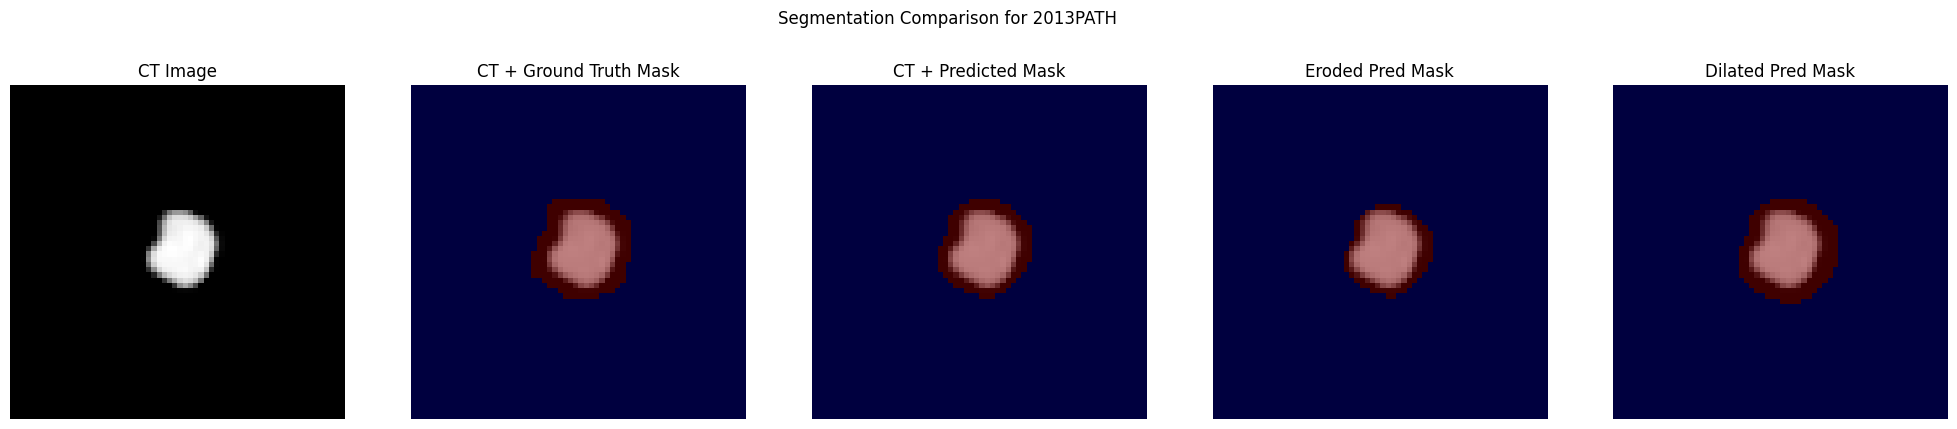

Patient: 2011PIDO / CT-Plan-image.nii.gz
32
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 5339 GT Pixel Count: 5061
Shrunk Predicted Pixel Count: 4655 Expanded Predicted Pixel Count: 6061


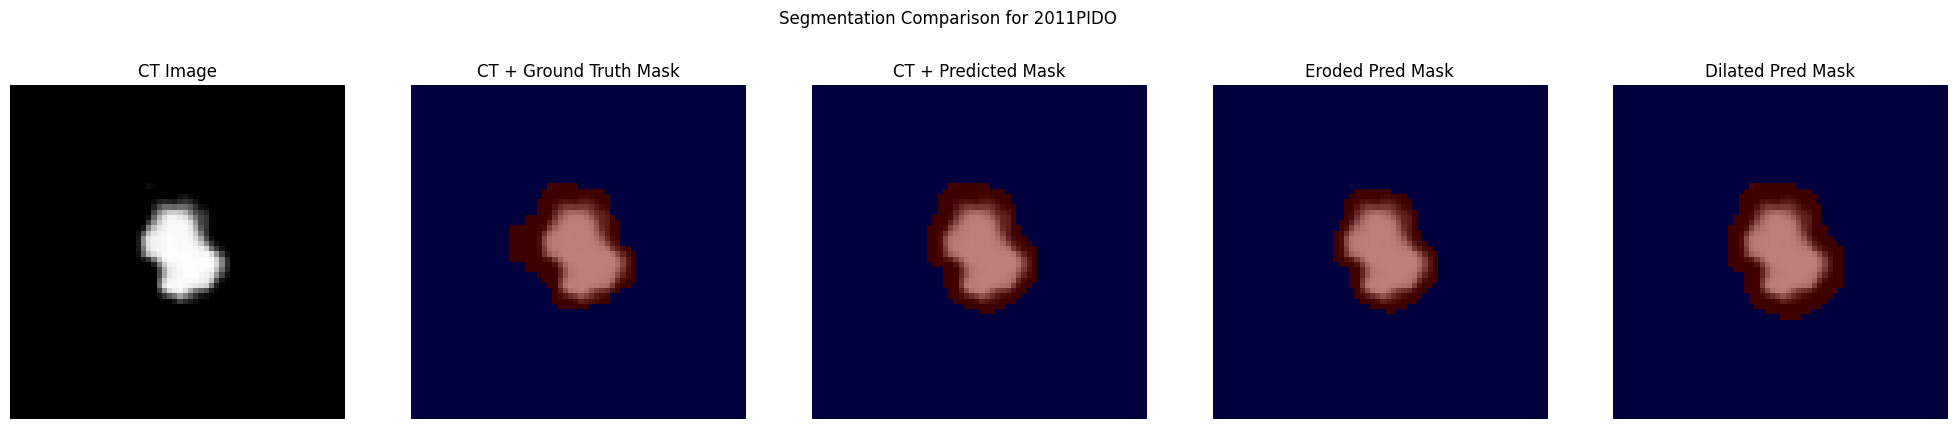

Patient: 2012LEBO / CT-Plan-image.nii.gz
31
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 34410 GT Pixel Count: 37937
Shrunk Predicted Pixel Count: 31771 Expanded Predicted Pixel Count: 37133


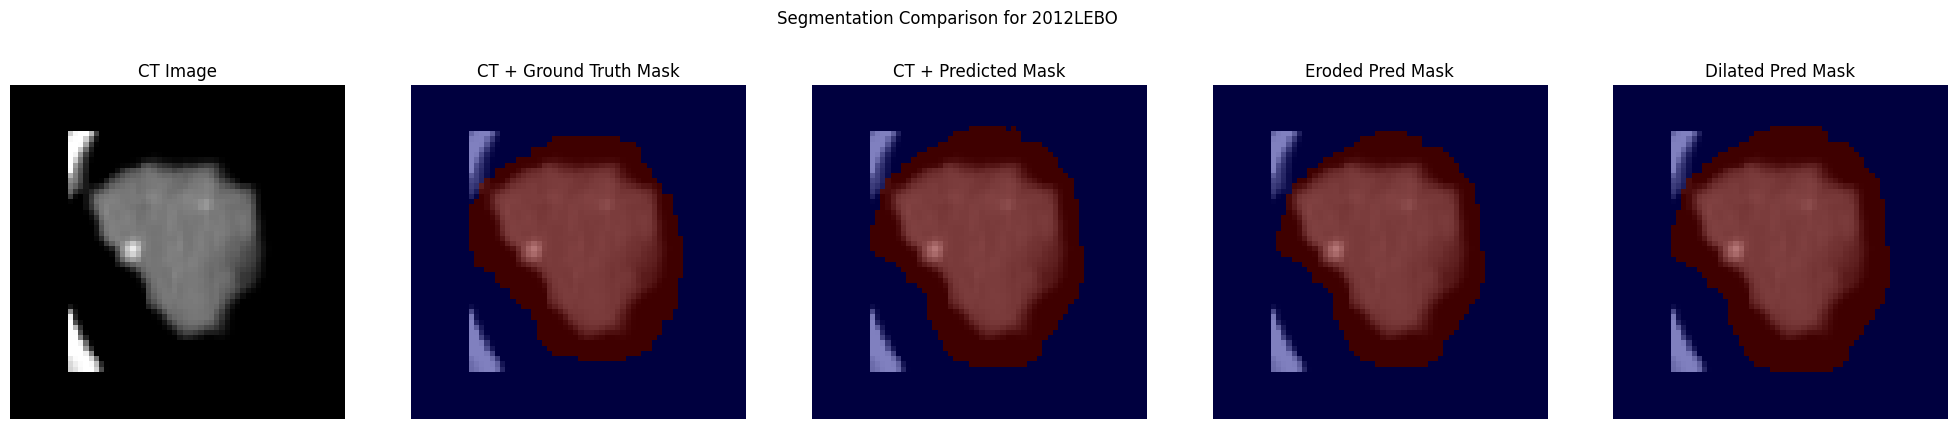

Patient: 2017REST / CT-Plan-image.nii.gz
32
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Predicted Pixel Count: 6909 GT Pixel Count: 5542
Shrunk Predicted Pixel Count: 6127 Expanded Predicted Pixel Count: 7732


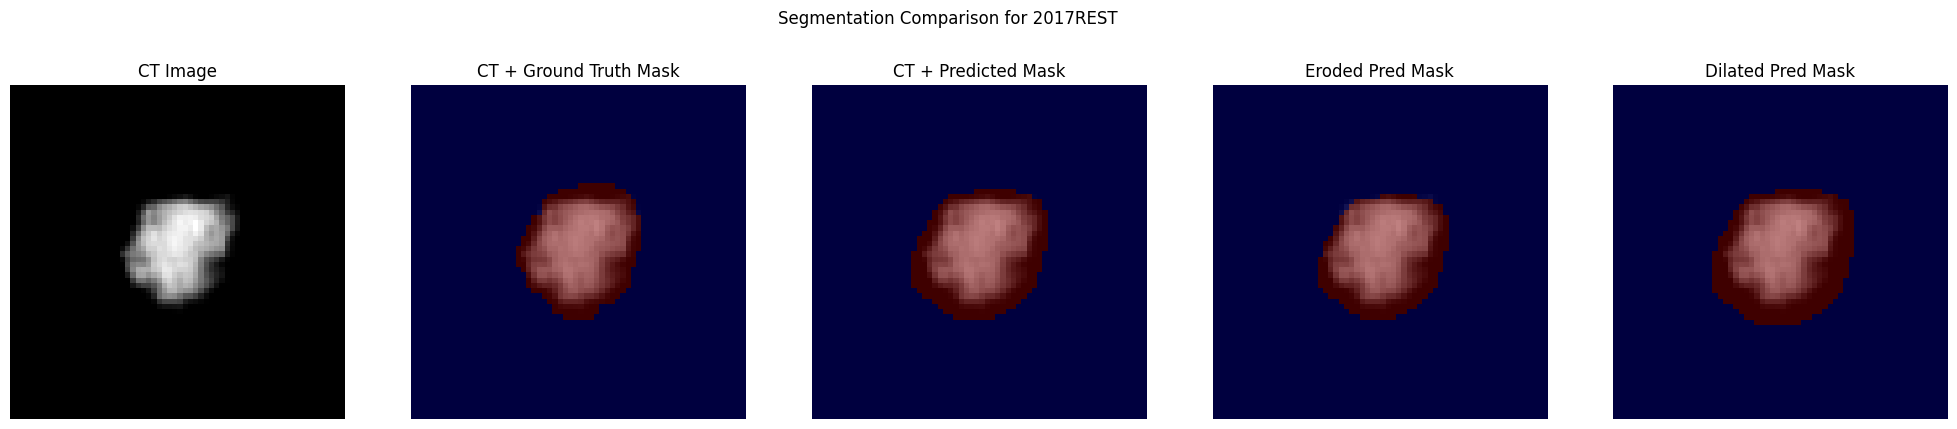

Mean Dice Per Class (Original): [0.99590374 0.8093548 ]
Mean Dice Per Class (Expanded): [0.99559496 0.78706075]
Mean Dice Per Class (Shrunk): [0.99531147 0.77811779]
Overall Mean Dice: 0.8935572504997253
Results saved to /home/ilkin/Documents/2024PHD/segmentation/swinunetr/tests/OH-GLLES-3D/s4/fold_5/dice_scores_expand_shrink_output.txt
Pixel counts saved to predicted_pixel_counts.csv


In [160]:
#Comparison of erotion/dilation


import torch
import numpy as np
import cv2  # Ensure OpenCV is installed
import random
from monai.transforms import AsDiscrete
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

post_label = AsDiscrete(to_onehot=numberofclasses+1)
post_pred = AsDiscrete(argmax=True, to_onehot=numberofclasses+1)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

meandiceperclass = np.zeros([numberofclasses+1])
expanded_meandiceperclass = np.zeros([numberofclasses+1])  # For expanded prediction
shrunk_meandiceperclass = np.zeros([numberofclasses+1])  # For shrunk prediction

# Open a file to save the results
output_file = f"{fold_dir}/dice_scores_expand_shrink_output.txt"
with open(output_file, "w") as f:  # 'w' mode ensures old content is erased
    f.write("Patient-wise Dice Scores and Mean Dice Score:\n\n")
pixel_data = []  # Store pixel count information

def get_middle_tumor_slice(mask):
    """Find the middle slice of the tumor region."""
    tumor_slices = np.where(mask.sum(axis=(0, 1)) > 0)[0]  # Find slices containing tumor
    if len(tumor_slices) > 0:
        return tumor_slices[len(tumor_slices) // 2]  # Return middle tumor slice
    return mask.shape[2] // 2  # Default to middle slice if no tumor detected

def visualize_segmentation(ct_image, mask, pred_mask, dilated_mask, eroded_mask, patient_name):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    
    axes[0].imshow(ct_image, cmap="gray")
    axes[0].set_title("CT Image")
    axes[0].axis("off")
    
    axes[1].imshow(ct_image, cmap="gray")
    axes[1].imshow(mask, cmap="jet", alpha=0.5)
    axes[1].set_title("CT + Ground Truth Mask")
    axes[1].axis("off")
    
    axes[2].imshow(ct_image, cmap="gray")
    axes[2].imshow(pred_mask, cmap="jet", alpha=0.5)
    axes[2].set_title("CT + Predicted Mask")
    axes[2].axis("off")
    
    axes[3].imshow(ct_image, cmap="gray")
    axes[3].imshow(dilated_mask, cmap="jet", alpha=0.5)
    axes[3].set_title("Eroded Pred Mask")
    axes[3].axis("off")
    
    axes[4].imshow(ct_image, cmap="gray")
    axes[4].imshow(eroded_mask, cmap="jet", alpha=0.5)
    axes[4].set_title("Dilated Pred Mask")
    axes[4].axis("off")
    
    plt.suptitle(f"Segmentation Comparison for {patient_name}")
    plt.show()


with torch.no_grad():
    for step, batch in enumerate(test_loader):
        pt_name = fold_splits[fold_idx]["test_files"][step]["image"].split("/")[-2]
        patient_info = f"Patient: {pt_name} / {fold_splits[fold_idx]['test_files'][step]['image'].split('/')[-1]}"
        print(patient_info)

        val_inputs, val_labels = (batch["image"].cuda(), batch["mask"].cuda())
        slice_idx = get_middle_tumor_slice(val_labels.squeeze().cpu().numpy())
        print(slice_idx)

        with torch.cuda.amp.autocast():
            val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model, overlap=0.5)
        
        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
        val_outputs_list = decollate_batch(val_outputs)
        val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]

        # Compute Original Dice Score
        dm = dice_metric(y_pred=val_output_convert, y=val_labels_convert)

        # Morphological Operations Setup
        kernel = np.ones((2, 2), np.uint8)  # 2x2 kernel for dilation/erosion

        # **EXPANDED (Dilated) Prediction**
        expanded_val_output_convert = []
        for tensor_pred in val_output_convert:
            np_pred = tensor_pred.cpu().numpy().astype(np.uint8)
            expanded_pred = np.zeros_like(np_pred)

            for c in range(np_pred.shape[0]):  
                expanded_pred[c] = cv2.dilate(np_pred[c], kernel, iterations=1)  # Dilation

            expanded_val_output_convert.append(torch.tensor(expanded_pred, dtype=torch.float32).cuda())

        expanded_dm = dice_metric(y_pred=expanded_val_output_convert, y=val_labels_convert)

        # **SHRUNK (Eroded) Prediction**
        shrunk_val_output_convert = []
        for tensor_pred in val_output_convert:
            np_pred = tensor_pred.cpu().numpy().astype(np.uint8)
            shrunk_pred = np.zeros_like(np_pred)

            for c in range(np_pred.shape[0]):  
                shrunk_pred[c] = cv2.erode(np_pred[c], kernel, iterations=1)  # Erosion

            shrunk_val_output_convert.append(torch.tensor(shrunk_pred, dtype=torch.float32).cuda())

        shrunk_dm = dice_metric(y_pred=shrunk_val_output_convert, y=val_labels_convert)

        # Save per-class Dice scores for this patient to file
        with open(output_file, "a") as f:
            f.write(f"\n{patient_info}\n")
            f.write(f"Original Dice scores: {dm[0].cpu().numpy().tolist()}\n")
            f.write(f"Expanded Dice scores: {expanded_dm[0].cpu().numpy().tolist()}\n")
            f.write(f"Shrunk Dice scores: {shrunk_dm[0].cpu().numpy().tolist()}\n")
            f.flush()

        # Accumulate Dice scores for averaging
        meandiceperclass += dm[0].cpu().numpy()
        expanded_meandiceperclass += expanded_dm[0].cpu().numpy()
        shrunk_meandiceperclass += shrunk_dm[0].cpu().numpy()

        # Ensure the masks are correctly squeezed to remove batch and channel dimensions
        pred_mask = val_output_convert[0][1].cpu().numpy().squeeze()  # Remove extra dims
        gt_mask = val_labels_convert[0][1].cpu().numpy().squeeze()  # Remove extra dims
        shrunk_pred_mask = shrunk_val_output_convert[0][1].cpu().numpy().squeeze()  # Remove extra dims
        expanded_pred_mask = expanded_val_output_convert[0][1].cpu().numpy().squeeze()  # Remove extra dims

        # Compute pixel counts (counting nonzero pixels)
        pred_pixel_count = np.sum(pred_mask > 0)  # Count non-background pixels
        gt_pixel_count = np.sum(gt_mask > 0)  # Count non-background pixels
        shrunk_pred_pixel_count = np.sum(shrunk_pred_mask > 0)  # Count non-background pixels
        expanded_pred_pixel_count = np.sum(expanded_pred_mask > 0)  # Count non-background pixels

        # Print unique values and check shapes
        print("Pred Mask Shape:", pred_mask.shape, "Unique Values:", np.unique(pred_mask))
        print("GT Mask Shape:", gt_mask.shape, "Unique Values:", np.unique(gt_mask))
        print("Predicted Pixel Count:", pred_pixel_count, "GT Pixel Count:", gt_pixel_count)
        print("Shrunk Predicted Pixel Count:", shrunk_pred_pixel_count, "Expanded Predicted Pixel Count:", expanded_pred_pixel_count)

        pixel_data.append({
            "Patient": pt_name,
            "GT_Pixels": gt_pixel_count,
            "Predicted_Pixels": pred_pixel_count,
            "Shrunk_Pixels": shrunk_pred_pixel_count,
            "Expanded_Pixels": expanded_pred_pixel_count
        })

        visualize_segmentation(val_inputs.squeeze().cpu().numpy()[:,:,slice_idx], 
                               val_labels.squeeze().cpu().numpy()[:,:,slice_idx], 
                               pred_mask[:,:,slice_idx], 
                               shrunk_pred_mask[:,:,slice_idx],
                               expanded_pred_mask[:,:,slice_idx], 
                               pt_name)


    # Compute mean Dice scores
    meandiceperclass /= (step + 1)
    expanded_meandiceperclass /= (step + 1)
    shrunk_meandiceperclass /= (step + 1)

    mean_dice_val = dice_metric.aggregate().item()
    dice_metric.reset()

    # Print mean Dice scores
    print("Mean Dice Per Class (Original):", meandiceperclass)
    print("Mean Dice Per Class (Expanded):", expanded_meandiceperclass)
    print("Mean Dice Per Class (Shrunk):", shrunk_meandiceperclass)
    print("Overall Mean Dice:", mean_dice_val)

    # Save mean Dice scores to file
    with open(output_file, "a") as f:
        f.write("\nMean Dice Per Class (Original):\n")
        f.write(f"{meandiceperclass.tolist()}\n")
        f.write("\nMean Dice Per Class (Expanded):\n")
        f.write(f"{expanded_meandiceperclass.tolist()}\n")
        f.write("\nMean Dice Per Class (Shrunk):\n")
        f.write(f"{shrunk_meandiceperclass.tolist()}\n")
        f.write("\nOverall Mean Dice:\n")
        f.write(f"{mean_dice_val}\n")

print(f"Results saved to {output_file}")

# Save pixel count data to CSV
pixel_df = pd.DataFrame(pixel_data)
pixel_df.to_csv("predicted_pixel_counts.csv", index=False)
print("Pixel counts saved to predicted_pixel_counts.csv")



In [155]:
# Comparison of edge addition using Canny edge detection
test_transforms = transforms2.getTestTransformROI(-175, 250)
# Create test dataset and loader
test_dataset = Dataset(data=fold_splits[fold_idx]["test_files"], transform=test_transforms)
# Evaluation on Test Data
test_loader = DataLoader(
    CacheDataset(data=fold_splits[fold_idx]["test_files"], transform=test_transforms, cache_rate=0.1, num_workers=4),
    batch_size=batchsize, shuffle=True, num_workers=4
)

import torch
import numpy as np
import cv2  # Ensure OpenCV is installed
import random
import pandas as pd
from monai.transforms import AsDiscrete
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

post_label = AsDiscrete(to_onehot=numberofclasses+1)
post_pred = AsDiscrete(argmax=True, to_onehot=numberofclasses+1)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

meandiceperclass = np.zeros([numberofclasses+1])
edges_added_meandiceperclass = np.zeros([numberofclasses+1])  # For expanded prediction

# Open a file to save the results
output_file = f"{fold_dir}/dice_scores_edge_added_output.txt"
pixel_data = []  # Store pixel count information

with open(output_file, "w") as f:  # 'w' mode ensures old content is erased
    f.write("Patient-wise Dice Scores and Mean Dice Score:\n\n")

def add_canny_edges(pred_mask, ct_image, low_threshold=50, high_threshold=150):
    """Add Canny edges from the 3D CT image to the prediction mask if touching the existing mask."""
    
    # Ensure the input arrays are binary masks
    pred_mask = (pred_mask > 0).astype(np.uint8)
    
    # Copy the prediction mask
    modified_mask = pred_mask.copy()
    
    # Define a kernel for dilation
    kernel = np.ones((3, 3), np.uint8)
    
    # Initialize edge mask
    edge_mask = np.zeros_like(pred_mask, dtype=np.uint8)
    
    # Process each slice independently
    for i in range(ct_image.shape[0]):
        # Apply Canny edge detection
        edges = cv2.Canny((ct_image[i] * 255).astype(np.uint8), low_threshold, high_threshold)
        
        # Store edges in the edge mask
        edge_mask[i] = (edges > 0).astype(np.uint8)
        
        # Get the coordinates of edge pixels
        edge_indices = np.argwhere(edges > 0)
        
        # Dilate the prediction mask for the current slice
        dilated_mask = cv2.dilate(modified_mask[i], kernel, iterations=1)
        
        # Ensure dilated_mask is properly indexed as a single value
        for y, x in edge_indices:
            if 0 <= y < dilated_mask.shape[0] and 0 <= x < dilated_mask.shape[1]:
                if dilated_mask[y, x] == 1:
                    modified_mask[i, y, x] = 1
    print("debug funct", pred_mask.shape, modified_mask.shape)
    return modified_mask, edge_mask

with torch.no_grad():
    for step, batch in enumerate(test_loader):
        pt_name = fold_splits[fold_idx]["test_files"][step]["image"].split("/")[-2]
        patient_info = f"Patient: {pt_name} / {fold_splits[fold_idx]['test_files'][step]['image'].split('/')[-1]}"
        print(patient_info)

        val_inputs, val_labels = (batch["image"].cuda(), batch["mask"].cuda())
        slice_idx = get_middle_tumor_slice(val_labels.squeeze().cpu().numpy())

        with torch.cuda.amp.autocast():
            val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model, overlap=0.5)
        
        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
        val_outputs_list = decollate_batch(val_outputs)
        val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
        #print(val_output_convert.shape,"fff")
        # Compute Original Dice Score
        dm = dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        #print(val_output_convert.shape)
        # Ensure the masks are correctly squeezed to remove batch and channel dimensions
        pred_mask = val_output_convert[0][1].cpu().numpy().squeeze()  # Remove extra dims
        gt_mask = val_labels_convert[0][1].cpu().numpy().squeeze()  # Remove extra dims
        ct_slice = val_inputs.squeeze().cpu().numpy()  # Extract CT slice

        # Add edges using Canny edge detection if touching predicted mask
        edge_added_mask, edge_mask = add_canny_edges(pred_mask, ct_slice)

################################

        # Convert NumPy arrays to PyTorch tensors
        edge_added_mask_tensor = torch.tensor(edge_added_mask, dtype=torch.float32).cuda()

        # Ensure correct dimensions: (B, C, D, H, W)
        edge_added_mask_tensor = edge_added_mask_tensor.unsqueeze(0).unsqueeze(0)

        # Compute Dice metric
        dm_edge = dice_metric(y_pred=edge_added_mask_tensor, y=val_labels_convert)
        print(dm_edge.shape)

################################
        # Compute pixel counts (counting nonzero pixels)
        pred_pixel_count = np.sum(pred_mask > 0)  # Count non-background pixels
        gt_pixel_count = np.sum(gt_mask > 0)  # Count non-background pixels
        edge_added_pixel_count = np.sum(edge_added_mask > 0)  # Count non-background pixels
        
        # Accumulate Dice scores for averaging
        meandiceperclass += dm[0].cpu().numpy()
        
        edges_added_meandiceperclass += dm_edge[0].cpu().numpy()
        
        # Print unique values and check shapes
        print("Pred Mask Shape:", pred_mask.shape, "Unique Values:", np.unique(pred_mask))
        print("GT Mask Shape:", gt_mask.shape, "Unique Values:", np.unique(gt_mask))
        print("Edge Added Mask Shape:", edge_added_mask.shape, "Unique Values:", np.unique(edge_added_mask))

        print("Predicted Pixel Count:", pred_pixel_count, "GT Pixel Count:", gt_pixel_count)
        print("Edge-Added Predicted Pixel Count:", edge_added_pixel_count)

        pixel_data.append({
            "Patient": pt_name,
            "GT_Pixels": gt_pixel_count,
            "Predicted_Pixels": pred_pixel_count,
            "Edge_Added_Pixels": edge_added_pixel_count
        })

        #visualize_segmentation(val_inputs.squeeze().cpu().numpy()[:,:,slice_idx], 
        #                       val_labels.squeeze().cpu().numpy()[:,:,slice_idx], 
        #                       pred_mask[:,:,slice_idx], 
        #                       edge_mask[:,:,slice_idx], 
        #                       edge_added_mask[:,:,slice_idx],
        #                       patient_name)



    # Compute mean Dice scores
    meandiceperclass /= (step + 1)
    edges_added_meandiceperclass /= (step + 1)

    #mean_dice_val = dice_metric.aggregate().item()
    #dice_metric.reset()

    # Print mean Dice scores
    print("Mean Dice Per Class (Original):", meandiceperclass)
    print("Mean Dice Per Class (Edges Added):", edges_added_meandiceperclass)
    print("Overall Mean Dice:", mean_dice_val)

    # Save mean Dice scores to file
    with open(output_file, "a") as f:
        f.write("\nMean Dice Per Class (Original):\n")
        f.write(f"{meandiceperclass.tolist()}\n")
        f.write("\nMean Dice Per Class (Edges Added):\n")
        f.write(f"{edges_added_meandiceperclass.tolist()}\n")
        f.write("\nOverall Mean Dice:\n")
        f.write(f"{mean_dice_val}\n")

print(f"Results saved to {output_file}")

# Save pixel count data to CSV
pixel_df = pd.DataFrame(pixel_data)
pixel_df.to_csv("predicted_pixel_counts_with_edges.csv", index=False)
print("Pixel counts saved to predicted_pixel_counts_with_edges.csv")


Loading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Patient: 2013KEFR / CT-Plan-image.nii.gz
debug funct (64, 64, 64) (64, 64, 64)
torch.Size([1, 1])
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Edge Added Mask Shape: (64, 64, 64) Unique Values: [0 1]
Predicted Pixel Count: 1035 GT Pixel Count: 786
Edge-Added Predicted Pixel Count: 1059
Patient: 2013HOJA / CT-Plan-image.nii.gz
debug funct (64, 64, 64) (64, 64, 64)
torch.Size([1, 1])
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Edge Added Mask Shape: (64, 64, 64) Unique Values: [0 1]
Predicted Pixel Count: 4791 GT Pixel Count: 3784
Edge-Added Predicted Pixel Count: 4867
Patient: 2012JOJA / CT-Plan-image.nii.gz
debug funct (64, 64, 64) (64, 64, 64)
torch.Size([1, 1])
Pred Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
GT Mask Shape: (64, 64, 64) Unique Values: [0. 1.]
Edge Added Mask Shape: (64, 64, 64) Unique Values: [0 1]
Predicted Pixel Count: 5965 GT Pixel Count: 9320

/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


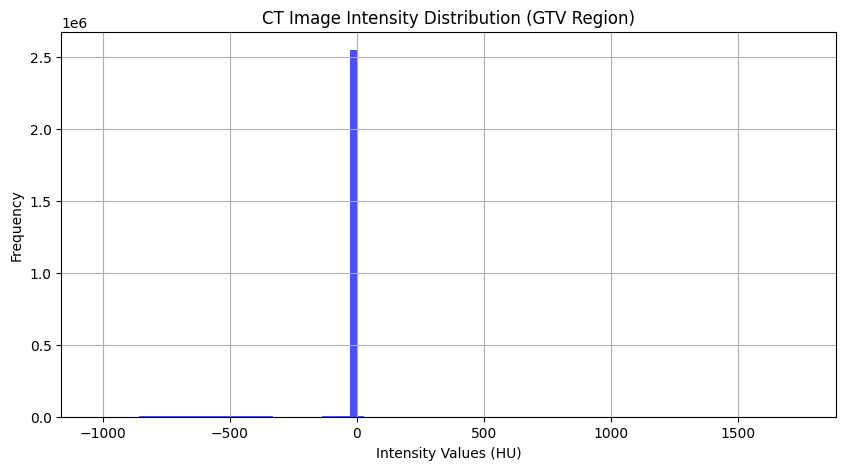

In [73]:
import numpy as np
import matplotlib.pyplot as plt

from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
    Resized,
    SpatialPadd,
    Transform
)
def getTestTransform():
    val_transforms = Compose(
        [
            LoadImaged(keys=["image", "mask"], ensure_channel_first=True),
            CropForegroundd(keys=["image", "mask"], source_key="mask"),
            Orientationd(keys=["image", "mask"], axcodes="RAS"),
            Spacingd(
                keys=["image", "mask"],
                pixdim=(1.0, 1.0, 1.0),
                mode=("bilinear", "nearest"),
            ),
            SpatialPadd(keys=["image", "mask"], spatial_size=(64, 64, 64), method="symmetric", mode="constant", constant_values=0),
            EnsureTyped(keys=["image", "mask"], track_meta=True),
        ]
    )
    return val_transforms

test_transforms = getTestTransform()
# Create test dataset and loader
test_dataset = Dataset(data=fold_splits[fold_idx]["test_files"], transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
# Extract image intensities from a few test cases
intensities = []
for idx, batch in enumerate(test_loader):
    if idx >= 10:  # Analyze 10 samples
        break
    image_np = batch["image"][0].squeeze().cpu().numpy()
    intensities.append(image_np.flatten())

# Combine all intensities
intensities = np.concatenate(intensities)

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(intensities, bins=100, color="blue", alpha=0.7)
plt.xlabel("Intensity Values (HU)")
plt.ylabel("Frequency")
plt.title("CT Image Intensity Distribution (GTV Region)")
plt.grid()
plt.show()
